# CS 8770 Project 1

## Part 1

### Load libs

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim

### Load data

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor())

dset = "MNIST"

In [4]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor())

dset = "FashionMNIST"

In [5]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Model definitions

In [6]:
class MLP(nn.Module):
    
    # H: list of hidden layer dims
    # phi: non-linearity to use
    # n_classes: num of classes to pred
    def __init__(self, H, phi=nn.ReLU(), n_classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential()
        # create hidden layers based off input list H
        H.insert(0,28*28) # input layer
        [self.layers.append(nn.Linear(h,l)).append(phi) for h, l in zip(H,H[1:])] # hidden layers
        self.layers.append(nn.Linear(H[-1],n_classes)) # output layer

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

In [7]:
# Single RBF Neuron
class RBFNeuron(nn.Module):

    # mu: RBF mu vector
    # sig: RBF sigma
    def __init__(self, mu, sig):
        super(RBFNeuron, self).__init__()
        self.mu = mu
        self.sig = sig

    def __call__(self, x):
        top = torch.linalg.norm(x-self.mu, dim=1)
        return torch.exp((-0.5)*(top.pow(2) / self.sig))

# Layer of RBF Neurons
class RBFLayer(nn.Module):

    # nin: input dim
    # nout: output dim
    # mus: list of mean vectors for RBF neurons
    # sigs: list of sigmas for RBF neurons
    def __init__(self, nin, nout, mus, sigs):
        super(RBFLayer, self).__init__()
        self.neurons = nn.ModuleList([RBFNeuron(mus[i],sigs[i]) for i in range(nout)])

    def __call__(self, x):
        return torch.tensor([f(x).detach().numpy() for f in self.neurons], dtype=torch.float32, requires_grad=False).transpose(0,1)

# Full RBF Network
class RBFNet(nn.Module):

    # mus: list of means to use in basis functions
    # sigs: list of sigmas to use in basis functions
    # n_classes: num of classes to pred
    def __init__(self, mus, sigs, n_classes=10):
        super(RBFNet, self).__init__()
        self.K = len(mus) # number of RBFs
        self.mus = nn.Parameter(mus)#, requires_grad=False)
        self.sigs = nn.Parameter(sigs)#, requires_grad=False)
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            RBFLayer(28*28, self.K, self.mus, self.sigs),
            nn.Linear(self.K, n_classes)
        )

    def forward(self, x):
        #x = (x-x.min())/(x.max()-x.min())
        #x = torch.tensor(x, dtype=torch.float32)
        x = self.flatten(x)
        x = torch.div(x, torch.linalg.vector_norm(x, dim=1).view(-1,1)) # unit norm x
        return self.layers(x)

In [8]:
class CNN(nn.Module):
    
    def __init__(self, n_channels, n_classes=10):
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=8,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=8, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.mlp = nn.Sequential(
            nn.Linear(7*7*64, 64),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.mlp(x)

### Train (& validation / test?) loops

In [9]:
from tqdm.notebook import tqdm # status bar

def train(model, data, loss_fn, optimizer, epochs=5):

    for epoch in range(epochs):

        epoch_loss = []

        for batch, (samples, labels) in enumerate(tqdm(data)):

            # we need to convert these into tensors
            #samples = samples.type('torch.FloatTensor')
            #labels = labels.type('torch.LongTensor')

            # forward pass
            prediction = model(samples)
            loss = loss_fn(prediction, labels)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record loss
            epoch_loss.append(loss.item())

        # keep track of loss over our batches
        #epoch_loss = statistics.mean(epoch_loss)
        print(loss)

In [10]:
def test(model, data, loss_fn):

    for batch, (samples, labels) in enumerate(tqdm(data)):

        # we need to convert these into tensors
        #samples = samples.type('torch.FloatTensor')
        #labels = labels.type('torch.LongTensor')

        # forward pass
        prediction = model(samples)
        loss = loss_fn(prediction, labels)

    # test loss
    print(loss)

### Fit models

In [11]:
loss_fn = nn.CrossEntropyLoss()

In [12]:
# hyperparams
learning_rate = 1e-3
momentum = 0.3
epochs = 3

### MLP

In [13]:
mlp_model = MLP([256]*3, nn.ReLU(), n_classes=10)

optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)

In [14]:
train(mlp_model, train_dl, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.3600, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.2347, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.2244, grad_fn=<NllLossBackward0>)


In [15]:
test(mlp_model, test_dl, loss_fn)

  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.0853, grad_fn=<NllLossBackward0>)


In [ ]:
for l in range(0,8,2):
    U,S,V = torch.svd_lowrank(mlp_model.layers[l].weight, q=32)
    mlp_model.layers[l].weight.data = U @ S.diag() @ V.T

### RBF

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(100, init='k-means++', n_init='auto', random_state=0)
kmeans.fit(train_data.data.flatten(1))
#klabels = kmeans.predict(train_data.data.flatten(1))
clusters = kmeans.cluster_centers_.astype(float)

In [18]:
mus = torch.from_numpy(clusters)
sigs = torch.ones(len(mus))*5e-1

# mus = train_data.data.flatten(1)[:512].float() # just make mus the train data itself
# sigs = torch.ones(len(mus))*5e-1

mus = torch.div(mus, torch.linalg.vector_norm(mus, dim=1).view(-1,1)) # unit norm means

In [19]:
x = train_data.data.flatten(1)[:batch_size]

mu = mus[1]
sig = torch.ones(1)*5e-1

# x.shape
x = torch.tensor(x,dtype=torch.float32)
# torch.linalg.vector_norm(x,dim=1).view(-1,1)

x = torch.div(x, torch.linalg.vector_norm(x, dim=1).view(-1,1)) # unit norm x

RBFNeuron(mu, sig)(x)

/var/folders/nl/b0l1g5b56h54lzcs1jywtm4h0000gn/T/ipykernel_14388/429756271.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)


tensor([0.5288, 0.7579, 0.6882, 0.7573, 0.6960, 0.7400, 0.3765, 0.6887, 0.2719,
        0.3348, 0.7843, 0.6396, 0.4176, 0.3388, 0.2965, 0.4696, 0.6876, 0.8177,
        0.8044, 0.7388, 0.7176, 0.6456, 0.8097, 0.5377, 0.9088, 0.7633, 0.6958,
        0.7911, 0.8428, 0.8368, 0.2742, 0.6548, 0.8615, 0.4903, 0.6050, 0.6113,
        0.4389, 0.6481, 0.5888, 0.9031, 0.8255, 0.3764, 0.4600, 0.3655, 0.5546,
        0.8242, 0.3746, 0.7882, 0.7441, 0.8676, 0.6574, 0.6766, 0.4052, 0.8798,
        0.8256, 0.8494, 0.6550, 0.6714, 0.6612, 0.5289, 0.4283, 0.7984, 0.3156,
        0.2453, 0.7291, 0.8140, 0.8126, 0.6728, 0.7430, 0.5259, 0.7529, 0.6363,
        0.7580, 0.6949, 0.5864, 0.9029, 0.6932, 0.7801, 0.5507, 0.4967, 0.6241,
        0.6098, 0.3168, 0.3889, 0.5258, 0.4362, 0.6071, 0.3314, 0.5614, 0.4386,
        0.4503, 0.5865, 0.6485, 0.4696, 0.7482, 0.8358, 0.6390, 0.5401, 0.7247,
        0.5564, 0.5999, 0.7249, 0.5394, 0.5120, 0.8119, 0.5980, 0.6117, 0.4399,
        0.3975, 0.5483, 0.5353, 0.3724, 

In [20]:
train_data.targets[:batch_size]

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7,
        5, 5, 9, 2, 2, 2, 7, 6])

In [21]:
rbf_model = RBFNet(mus, sigs, n_classes=10)

optimizer = optim.Adam(rbf_model.parameters(), lr=learning_rate)

In [27]:
train(rbf_model, train_dl, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.7324, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8254, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.6865, grad_fn=<NllLossBackward0>)


In [28]:
test(rbf_model, test_dl, loss_fn)

  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.6469, grad_fn=<NllLossBackward0>)


### CNN

In [29]:
cnn_model = CNN(n_channels=1, n_classes=10)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [30]:
train(cnn_model, train_dl, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.5048, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.4374, grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.3086, grad_fn=<NllLossBackward0>)


In [31]:
test(cnn_model, test_dl, loss_fn)

  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.3353, grad_fn=<NllLossBackward0>)


### Results

In [32]:
import seaborn as sn
import pandas as pd

In [33]:
digit_mnist_classes = np.arange(10)

fashion_mnist_classes = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

  0%|          | 0/10000 [00:00<?, ?it/s]

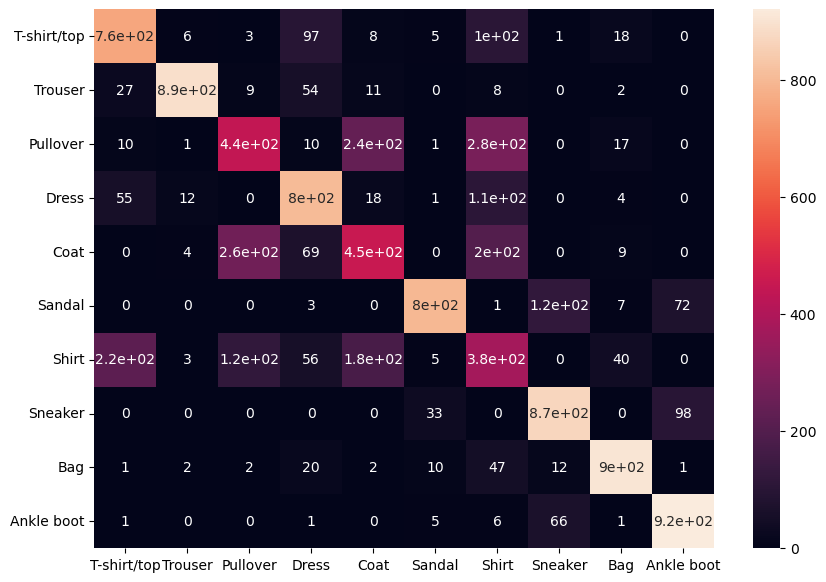

In [34]:
C = digit_mnist_classes if dset == "MNIST" else fashion_mnist_classes

# resub because we are loading our MNIST training data set
test_dl_2 = DataLoader(dataset=test_data, shuffle=True, batch_size=1)

model = rbf_model

confusion_mat = torch.zeros((10,10))
for sample, label in tqdm(test_dl_2):
    
    label = int(label.numpy())

    prediction = model(sample)
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).numpy())
    
    confusion_mat[label,prediction] += 1
    
df_cm = pd.DataFrame(np.asarray(confusion_mat),
                     index = [C[i] for i in np.arange(10)],
                     columns = [C[i] for i in np.arange(10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()